In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



Приветствую вас в демо-версии моего проекта по предиктивной аналитике успеваемости студентов!

# Для начала нам следует идентифицировать релевантные источники данных из доступных в нашем датасете OULAD.

Рассмотрим схему данных иллюстрирующую структуру данных датасета (доступно по ссылке https://analyse.kmi.open.ac.uk/open_dataset).

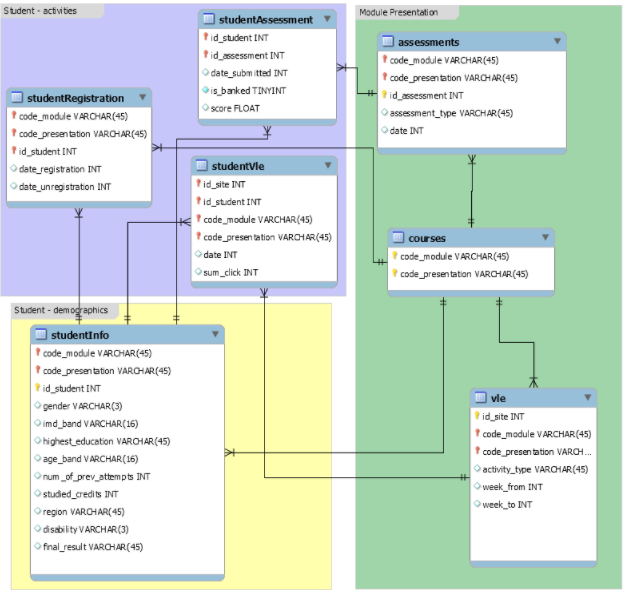

Как можно увидеть - разнообразных данных здесь много,но так как мы хотим предсказывать успеваемость студентов то полезно было бы рассмотреть следующие признаки:

* Меры показывающие ответственность либо приверженность студентов учебному процессу за некий период

* Меру их учебной прозводительности за некоторый период

* Оценки студентов по мере завершения прохождения некоторого ряда курсов (итоговые оценки)

На сайте датасета указано что нужные нам данные содержатся в следующих таблицах:

- studentInfo
- studentAssessment
- assessments
- studentVle
- vle

Эти таблицы и станут нашими источниками данных при построении моделей

In [ ]:
studInfo=pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/anonymiseddata/studentInfo.csv")
assessments=pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/anonymiseddata/assessments.csv")
studAss=pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/anonymiseddata/studentAssessment.csv")
studVle=pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/anonymiseddata/studentVle.csv")
vle=pd.read_csv("/kaggle/input/open-university-learning-analytics-dataset/anonymiseddata/vle.csv")

# Часть 1: Выбор характеристик и инженерия структур данных

# Оценки из контрольных испытаний (проверочных работ)

Оценка учебной производительности является для нас интересной так как она вносит вклад в вероятности исходов (итоговых оценок). Но ввиду наличия большого количства курсов было бы нерационально создавать отдельное табличное поле для каждого из них. Чтобы обойти эту поблему мы создадим 2 поля, одно из которых является оценкой, второй - вес конкретного испытания.

In [ ]:
exams=assessments[assessments["assessment_type"]=="Exam"]
others=assessments[assessments["assessment_type"]!="Exam"]
amounts=others.groupby(["code_module","code_presentation"]).count()["id_assessment"] 
amounts=amounts.reset_index()
amounts.head()
#Здесь мы включаем в данные все оценки по всем курсам

In [ ]:
#Функция пересчета прохождения испытания в бинарные Булевы значения
def pass_fail(grade):
    if grade>=40:
        return True
    else:
        return False
#Создадим датафрейм pandas со всеми данными по оценкам
stud_ass=pd.merge(studAss,others,how="inner",on=["id_assessment"])
stud_ass["pass"]=stud_ass["score"].apply(pass_fail)
stud_ass["weighted_grade"]=stud_ass["score"]*stud_ass["weight"]/100

In [ ]:
#Вычислим среднее по студенту по модулю
avg_grade=stud_ass.groupby(["id_student","code_module","code_presentation"]).sum()["weighted_grade"].reset_index()
avg_grade.head()

In [ ]:
#Вычислим общий процент прохождения испытаний
pass_rate=pd.merge((stud_ass[stud_ass["pass"]==True].groupby(["id_student","code_module","code_presentation"]).count()["pass"]).reset_index(),amounts,how="left",on=["code_module","code_presentation"])
pass_rate["pass_rate"]=pass_rate["pass"]/pass_rate["id_assessment"]
pass_rate.drop(["pass","id_assessment"], axis=1,inplace=True)
pass_rate.head()

In [ ]:
#Добавим оценки по финальным испытаниям
stud_exams=pd.merge(studAss,exams,how="inner",on=["id_assessment"])
stud_exams["exam_score"]=stud_exams["score"]
stud_exams.drop(["id_assessment","date_submitted","is_banked", "score","assessment_type","date","weight"],axis=1,inplace=True)
stud_exams.head()

# VLE

Наборы данных, относящиеся к VLE (Virtual Learning Environment), содержат интерактивную ленту студентов с контентом, доступным для справки на протяжении всего периода. Из этих данных мы можем сделать вывод, насколько учащийся был в контакте со своими предметами, изучали ли они его на прочной основе и как они использовали содержание.

In [ ]:
vle

In [ ]:
vle[~vle["week_from"].isna()]


In [ ]:
studVle.head()

In [ ]:
#Здесь мы можем вытащить данные о времени начала использования студентом справочных материалов после начала курса
#а также средние значения кликов на материал
avg_per_site=studVle.groupby(["id_student","id_site","code_module","code_presentation"]).mean().reset_index()
avg_per_site.head()

In [ ]:
#Вычислим общее среднее по всем студентам
avg_per_student=avg_per_site.groupby(["id_student","code_module","code_presentation"]).mean()[["date","sum_click"]].reset_index()
avg_per_student.head()

# StudentInfo

Таблица studentInfo содержит различную информацию о студентах, но для нашего анализа важными являются:

* Количество раз, когда студент уже пытался закончить модуль
* Окончательный результат студентов

Последний - наша переменная интереса при построении нашей модели прогноза.

In [ ]:
#Удалим случаи с отказом студента в прохождении курса
studInfo=studInfo[studInfo["final_result"]!="Withdrawn"]
studInfo=studInfo[["code_module","code_presentation","id_student","num_of_prev_attempts","final_result"]]
studInfo.head()

# Скомпилируем все релевантные таблицы

In [ ]:
df_1=pd.merge(avg_grade,pass_rate,how="inner",on=["id_student","code_module","code_presentation"])
assessment_info=pd.merge(df_1, stud_exams, how="inner", on=["id_student","code_module","code_presentation"])
assessment_info.head()

In [ ]:
df_2=pd.merge(studInfo,assessment_info,how="inner",on=["id_student","code_module","code_presentation"])
final_df=pd.merge(df_2,avg_per_student,how="inner", on=["id_student","code_module","code_presentation"])
final_df.drop(["id_student","code_module","code_presentation"],axis=1,inplace=True)
final_df.head()
#В конечном датафрейме оставлена только релевантная информация

# Часть 2: Исследовательский анализ данных

Начнем с проверки целостности всех данных в нашей выборке

In [ ]:
final_df.describe()

In [ ]:
final_df.info()

# Тот факт, что целевой признак является категориальным, не позволяет нам включить его в корреляционную матрицу, но мы можем видеть тенденцию корреляции между признаками-оценками. (*weighted_grade, pass_rate* и *exam_score*)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(final_df.corr(),annot=True)

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=final_df, x="final_result")

# Поскольку примеров данных с результатами "Pass" на курсах-зачетах сильно больше чем других - мы имеем дело с несбалансированным набором данных а это значит что нам придется внимательно следить за составом данных в дальнейшем и за производительностью модели. 

In [ ]:
sns.pairplot(final_df)

# В информации от функции pairplot мы видим значительное количество outlier'ов а поэтомы выходящие из распределения экземпляры будут удалены иначе в данных будут находиться противоречия которые сильно осложнят работу модели

In [ ]:
final_df[final_df["sum_click"]>10]

In [ ]:
final_df[final_df["num_of_prev_attempts"]>4]

In [ ]:
final_df=final_df[final_df["sum_click"]<=10]
final_df=final_df[final_df["num_of_prev_attempts"]<=4]
final_df.head()

# Часть 3: Создание модели

Мы используем следующие техники для создания модели:

* Кроссвалидацию и F1 матрицы для оценки производительности модели
* Логистическую регрессию
* Линейный дискриминант анализ
* Random Forest классификаторы
* Классификаторы на основе нейронных сетей

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
X=final_df.drop("final_result", axis=1)
y=final_df["final_result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Из-за высокой корреляции между *weighted_grade* и *pass_rate* модели будут обучены на трех вариантах данных

In [ ]:
#1 contains both, 2 just pass_rate e 3 just weighted_grade
X1_test=X_test
X1_train=X_train
X2_test=X_test.drop("weighted_grade",axis=1)
X2_train=X_train.drop("weighted_grade",axis=1)
X3_test=X_test.drop("pass_rate",axis=1)
X3_train=X_train.drop("pass_rate",axis=1)

In [ ]:
scaler1=MinMaxScaler()
scaler2=MinMaxScaler()
scaler3=MinMaxScaler()

In [ ]:
X1_train=scaler1.fit_transform(X1_train)
X1_test=scaler1.transform(X1_test)
X2_train=scaler2.fit_transform(X2_train)
X2_test=scaler2.transform(X2_test)
X3_train=scaler3.fit_transform(X3_train)
X3_test=scaler3.transform(X3_test)

# Модель 1: Логистическая регрессия

In [ ]:
lr1=LogisticRegression(max_iter=10000)
lr1.fit(X1_train,y_train)
result_lr1=lr1.predict(X1_test)
print(confusion_matrix(y_test,result_lr1))
print("\n")
print(classification_report(y_test,result_lr1))

In [ ]:
lr2=LogisticRegression(max_iter=10000)
lr2.fit(X2_train,y_train)
result_lr2=lr2.predict(X2_test)
print(confusion_matrix(y_test,result_lr2))
print("\n")
print(classification_report(y_test,result_lr2))

In [ ]:
lr3=LogisticRegression(max_iter=10000)
lr3.fit(X3_train,y_train)
result_lr3=lr3.predict(X3_test)
print(confusion_matrix(y_test,result_lr3))
print("\n")
print(classification_report(y_test,result_lr3))

# Модель 2: Линейный дискриминант анализ

In [ ]:
lda1=LinearDiscriminantAnalysis()
lda1.fit_transform(X1_train,y_train)
result_lda1=lda1.predict(X1_test)
print(confusion_matrix(y_test,result_lda1))
print("\n")
print(classification_report(y_test,result_lda1))

In [ ]:
lda2=LinearDiscriminantAnalysis()
lda2.fit_transform(X2_train,y_train)
result_lda2=lda2.predict(X2_test)
print(confusion_matrix(y_test,result_lda2))
print("\n")
print(classification_report(y_test,result_lda2))

In [ ]:
lda3=LinearDiscriminantAnalysis()
lda3.fit_transform(X3_train,y_train)
result_lda3=lda3.predict(X3_test)
print(confusion_matrix(y_test,result_lda3))
print("\n")
print(classification_report(y_test,result_lda3))

# Модель 3: Случайные леса

In [ ]:
rf1=RandomForestClassifier(n_estimators=300)
rf1.fit(X1_train,y_train)
result_rf1=rf1.predict(X1_test)
print(confusion_matrix(y_test,result_rf1))
print("\n")
print(classification_report(y_test,result_rf1))

In [ ]:
rf2=RandomForestClassifier(n_estimators=300)
rf2.fit(X2_train,y_train)
result_rf2=rf2.predict(X2_test)
print(confusion_matrix(y_test,result_rf2))
print("\n")
print(classification_report(y_test,result_rf2))

In [ ]:
rf3=RandomForestClassifier(n_estimators=300)
rf3.fit(X3_train,y_train)
result_rf3=rf3.predict(X3_test)
print(confusion_matrix(y_test,result_rf3))
print("\n")
print(classification_report(y_test,result_rf3))

# Модель 4: Классификатор на основе нейронной сети

In [ ]:
model1=Sequential()

model1.add(Dense(6, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(3, activation="relu"))
model1.add(Dense(1, activation="sigmoid"))

model1.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
model2=Sequential()

model2.add(Dense(5, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation="relu"))
model2.add(Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
model3=Sequential()

model3.add(Dense(5, activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(3, activation="relu"))
model3.add(Dense(1, activation="sigmoid"))

model3.compile(loss="binary_crossentropy", optimizer="adam")

In [ ]:
#For the neural network training, the outputs needed to be codified, and in order to avoid the ordinalization
#of the classes I chose to classify the distintion cases toghether with thw pass cases
def categories(cat):
    if cat=="Fail":
        return 0
    if cat=="Pass":
        return 1
    if cat=="Distinction":
        return 1
    
y_test=list(map(categories,y_test))
y_train=list(map(categories,y_train))

In [ ]:
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)
early_stop=EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=25)

In [ ]:
model1.fit(x=X1_train, y=y_train, epochs=2000, validation_data=(X1_test,y_test),callbacks=[early_stop])

In [ ]:
losses=pd.DataFrame(model1.history.history)
losses.plot()

In [ ]:
predictions=model1.predict_classes(X1_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

In [ ]:
model2.fit(x=X2_train, y=y_train, epochs=2000, validation_data=(X2_test,y_test),callbacks=[early_stop])

In [ ]:
losses=pd.DataFrame(model2.history.history)
losses.plot()

In [ ]:
predictions=model2.predict_classes(X2_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

In [ ]:
model3.fit(x=X3_train, y=y_train, epochs=2000, validation_data=(X3_test,y_test),callbacks=[early_stop])

In [ ]:
losses=pd.DataFrame(model3.history.history)
losses.plot()

In [ ]:
predictions=model3.predict_classes(X3_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))